This notebook will go through basic concepts of a regular work flow from preprocessing to evaluation trained models. 
In this particular example, we will be using Ski-kit learn Complement Naive bayer model to performance a multilabel classfication on 14 different YWCA report's labels.

In [4]:
!pip install -U scikit-learn

     |████████████████████████████████| 6.8MB 2.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


Loading dependancies for sci-kit learn, NLTK, and other basic utility python library

Display the sci-kit learn and NLTK versions.
 

In [51]:
import os, re
import gensim
import sklearn
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer
from sklearn.utils.class_weight import compute_sample_weight

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

print(f"NLTK's version is {nltk.__version__} , Sci-kit learn's version is {sklearn.__version__}")

NLTK's version is 3.2.5 , Sci-kit learn's version is 0.23.2


Download the NLTK punctuation pkg, stopwords pkg, wordnet pkg 

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

upload data-prcoessed.csv from local. This data-processed file is the output of current (before Aug 5th,2020) git main branch.


In [7]:
from google.colab import files
uploaded = files.upload()

Saving data-processed.csv to data-processed.csv


Read file by pandas. assign variable to target documents to be processed.
Display the first 5 samples.

In [8]:
yw_df = pd.read_csv("data-processed.csv")
yw_clean = yw_df["DESCRIPTION"]
yw_clean.head()

0    staff could hear ** make loud yelling noise fr...
1    this afternoon ** arrive at the building with ...
2    at approximately 1015pm ** enter building and ...
3    * be do shift exchange with staff when ** fell...
4    client ***** come into 417 at around 10pm ** b...
Name: DESCRIPTION, dtype: object

Standard NLTK tokenizer:
1.This remove stopwords and anything is not letters(words). 
2. Lemmatization is applied and wordnet lemmatizer is used. Snowball lemmatizer is a good alternative I can explore further later to compare and it also support built in stop word removal so code can be more elegant.
3. word are in its lower form
4. return a list of tokens => we can change to pandas dataframe but for illustration purpose, it should have the same output.

In [9]:
def nltk_tokenizer(df_sent):
    lemmatizer = nltk.WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    tokens = word_tokenize(df_sent)
    words = [word.lower() for word in tokens if word.isalpha()]  # get rid of puntuation
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]

    return words


Instead of a binary encoding in list comprehension. In here, I used sci-kit learn labelencoder to label the 14 catgories. The full information has been displayed in output.

In [35]:
encoder = LabelEncoder()
yw_txt_cats = encoder.fit_transform([t for t in yw_df['INCIDENT_TYPE_1']])

In [33]:
def count_weight(categories,total_files = yw_txt_cats):
  weight_dict = {lb:0 for lb in list(set(yw_txt_cats))}
  for cat in categories:
      weight_dict[cat] += 1 
   
  return weight_dict

In [34]:
weights_dict = count_weight(yw_txt_cats)
for i, cls in enumerate(encoder.classes_):
  print('{}. {} weights is : {:.2%}\n'.format(i,cls,weights_dict[i]/len(yw_txt_cats)))

0. Client aggression towards another person weights is : 11.34%

1. Client aggression towards property weights is : 0.90%

2. Client death (onsite) weights is : 0.90%

3. Concern for welfare of a child weights is : 4.48%

4. Homicide (Threat or attempt) weights is : 0.30%

5. Illegal activity on premises weights is : 0.30%

6. Injury weights is : 2.69%

7. Medical emergency weights is : 46.87%

8. Mental health emergency weights is : 5.97%

9. Other weights is : 12.84%

10. Security concern weights is : 4.78%

11. Suicide attempt weights is : 2.99%

12. Suspicion/allegation of abuse towards or against client weights is : 3.88%

13. nan weights is : 1.79%



I have tried both count vector and tfidf vector as I said in the meeting. The outcomes is Tfidf vector offer is marginal better result than count vector.

In [17]:
word_vec = TfidfVectorizer(tokenizer=nltk_tokenizer,
                                          token_pattern=r'\b\w+\b',
                                          ngram_range=(1, 2),
                                          min_df=2)
yw_clean = word_vec.fit_transform(yw_clean)

Split the data into train and test same way as CNB model in Cal's branch. I think we should also consider random setting to 0 to 42 and see how much our evaluation varies. I found if we set random state proper at 32 we can reach 77% accuracy, but if we dont set random_state. the accuracy change each time you rerun this cell and next cell together. 

Currently this notebook outputs showing at optimized accuracy score. you can experiement around to verify what I mean by removing random_state setting or change its value, then run the score cell after

In [41]:
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
                                        yw_clean, 
                                        yw_txt_cats,
                                        train_size=0.75,
                                        random_state = 32,
                                        shuffle = True)

weight_load = compute_sample_weight(weights_dict,yw_txt_cats)
weight_train,weight_test = train_test_split(
                                        weight_load,
                                        train_size=0.75,
                                        random_state = 32,
                                        shuffle = True)


array([157., 157., 157., 157.,  38.,  38., 157.,  43.,   9., 157.,  13.,
       157.,  15.,  38., 157., 157., 157., 157., 157., 157.,  43.,  13.,
        38., 157.,  13., 157., 157.,   3., 157.,   3.,  15., 157., 157.,
        38., 157., 157., 157., 157.,  43., 157., 157., 157., 157.,  43.,
       157., 157.,  16., 157., 157., 157.,  15., 157., 157., 157., 157.,
       157.,  20., 157., 157., 157.,  38.,  43.,  38., 157.,  38.,  38.,
         9., 157., 157.,  15., 157.,  43., 157.,  15., 157.,  15.,  43.,
        13.,  20.,   1.,  43.,  43., 157.,   3.])

train and score: accuracy score


In [54]:
cnb = ComplementNB()

cnb.fit(X_train_set,y_train_set,sample_weight = weight_train)
score_train = cnb.score(X_test_set, y_test_set,weight_test)
print("Accuracy score on test set is {0:.2f}".format(score_train))

Accuracy score on test set is 0.76


In [56]:
svm = SVC()
svm.fit(X_train_set,y_train_set,sample_weight = weight_train)
score_train = svm.score(X_test_set, y_test_set,weight_test)
print("Accuracy score on test set is {0:.2f}".format(score_train))

Accuracy score on test set is 0.92


Cross-Validation: We show what is the scores on train set with k = 5-fold to default. This is why we have 5 scores produced because 5 fold will provide 5 different validation sets

Here we run a basic validation. I will update more in the parameter to explore other evaluation matrix or settings

We also introduce a new matric for measuring cross-validation on our train set: balanced accuracy score.


In [66]:
scorer = make_scorer(balanced_accuracy_score)
cv_ = cross_validate(cnb,
                     X = X_train_set,
                     y = y_train_set,
                     scoring = ["balanced_accuracy","accuracy"]
                      )

cv_.keys()


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


dict_keys(['fit_time', 'score_time', 'test_balanced_accuracy', 'test_accuracy'])

This result from cross validation is significant. It shows we probably have some irregular data distribution between train set and test set. It also means that some how we are underfitting our model.

In [70]:
print("Cross-validation balanced accuracy average score on test set is {0:.2f}".format(np.average(cv_["test_balanced_accuracy"])))
print("raw scores is :")
cv_["test_balanced_accuracy"]

Cross-validation balanced accuracy average score on test set is 0.38
raw scores is :


array([0.39866194, 0.49833333, 0.34543487, 0.41774892, 0.24085006])

Just another to varify accuracy score on test set

In [71]:
predicted_ = cnb.predict(X_test_set)
accuracy_score(y_test_set,predicted_,sample_weight=weight_test)

0.7577393808495321

In [74]:
predicted_ = cnb.predict(X_train_set)
accuracy_score(y_train_set,predicted_,sample_weight=weight_train)

0.9799952141660684

Here is more clean version of balance accuracy score as our data is quite imbalanced. I think we may need to consider either shrink classes or figure out data-argumentation to create more sythetic, but with one example each for two of class we may need consider the first option.

In [72]:
predicted_ = cnb.predict(X_test_set)
balanced_accuracy_score(y_test_set,predicted_,sample_weight=weight_test)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.31904147861594667

In [73]:
predicted_ = cnb.predict(X_train_set)
balanced_accuracy_score(y_train_set,predicted_,sample_weight=weight_train)

0.7003111830698039

Bar chart shows how the data is distributed based on frequency. The array are name of catgories are  < 5 incidents. This is important because our cross-validation default to 5.

array(['Client aggression towards property', 'Client death (onsite)',
       'Homicide (Threat or attempt)', 'Illegal activity on premises'],
      dtype='<U55')

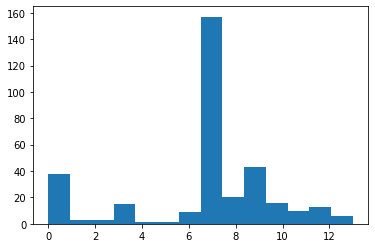

In [14]:

plt.hist(yw_txt_cats,bins = 14)

encoder.inverse_transform([1,2,4,5])

To go back our issue on different distribution between train set and test set. We can see train set has all the label classes, but test set has shorted 2 classes. Keep in mind we also set our random_state at 32 and manually optimized the result. The accuracy can drop to 58% with a different random_state settting from my experience 

In [15]:
set(y_train_set)


{0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13}

In [16]:
set(y_test_set)

{0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12}

Here is the block code to illustrate GridSearchCV. The purpose of gridsearch is hyperparameter fine tuning and cross-validate with cross-validation set ( in here, we have another minor problem to consider. As per Andrew N ML course, cross-validation should be similiar size as test set and different from train set). We use training set as both train and cross-validate. With very limited data right now I suggest we keep as only train and test as I have seen most practice out there only consider these type of split.

Another purpose of GridSearch is we can set number of n-folds in parameter and it will performance stratified kfold by default

In [50]:
# accuracy score feedback
param_grid = {'alpha':np.logspace(-5,0,6),
              }
print("Hyper-parameters for complementNB model are :")
print(cnb.get_params().keys())
grid = GridSearchCV(
    cnb,
    param_grid,
    cv =5)

grid.fit(X_train_set,y_train_set)
print("grid best score cross validation at {:.2%}".format(grid.best_score_))
print("best grid parameters are :{}".format(grid.best_params_))


Hyper-parameters for complementNB model are :
dict_keys(['alpha', 'class_prior', 'fit_prior', 'norm'])
grid best score cross validation at 60.17%
best grid parameters are :{'alpha': 1.0}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [32]:
# balanced accuracy score feedback
param_grid = {'alpha':np.logspace(-5,0,6),
              }
print("Hyper-parameters for complementNB model are :")
print(cnb.get_params().keys())
grid = GridSearchCV(cnb,param_grid,scoring = scorer,cv =5)
grid.fit(X_train_set,y_train_set)
print("grid best score cross validation at {:.2%}".format(grid.best_score_))
print("best grid parameters are :{}".format(grid.best_params_))

Hyper-parameters for complementNB model are :
dict_keys(['alpha', 'class_prior', 'fit_prior', 'norm'])
grid best score cross validation at 38.02%
best grid parameters are :{'alpha': 1.0}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dis

Comming soon I will add more into this notebook on more about data visualization and error evaluation to use heat-map to dig into more about our data